In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from mpl_toolkits.mplot3d import Axes3D

warnings.filterwarnings('ignore')

C:\Users\micsa\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Predicting the NBA MVP #
## Overview ##
Can stats predict who will win the NBA MVP award?  Let's find out!  This model attempts to answer that along with what features (stats) are most important in determining who has the highest liklihood of becoming MVP in any given season.
## Potential Pitfalls & Pratical Use ##
The biggest problems with any model that attempts to quantify and predict NBA MVP is that, for one, the data is completely unbalanced since only 1 player a year.  The other is narrative.  Stats alone do not win someone an MVP.  The award usually goes to a really good player on a really good team with a really good story.  Examples in the past have included great players going to new teams and having tremendous impacts right away, players who are in a 'breakout' year (as opposed to players with sustained success), or a "feel-good story" (someone has a great season after being injured for a while.

<br>
As for pratical uses of this model.  If you could predict who would win NBA MVP you'd clean up in your friends betting pools (or Vegas).

## Clean the Data & Feature Engineering ##

The base of the data was made up off a Kaggle dataset featuring NBA player stats between 1950-2017.  I then manually seeded the data with MVP voting statistics dating back to 1980 as well as the win/loss percentages of the teams each player played on.  While the dataset goes back all the way to the 1950's and includes every player who played in an NBA game, I imposed some strict filters on the data in order to reduce the number of players. <br> 

Since I was looking for players most likely to be in the running for MVP, I imposed games played and minutes per game restrictions of 41 games and 25 minutes on the data to filter out players who played well but did so in limited minutes as well as players that put up monster per game numbers but did not play enough games to really qualify for MVP contention.  Finally I droped all rows containing a nil-value, which effectively limited the player base to 1980 forward. Because the data did not come with it, I created 'per game' version of many of the total season stats available.  Overall, the restrictions limited the overall number of players from ~24k to 4750, while feature engineering increased the number of potential features from 57 to 65.

In [2]:
# Training Data
season_stats = pd.read_csv('Seasons_Stats.csv')
print(season_stats.shape)
season_stats = season_stats.drop(['blanl', 'blank2', 'Unnamed: 0'], axis=1)
season_stats = season_stats[season_stats.Tm.str.contains('TOT') == False]
season_stats['MVP_Candidate'] = np.where(season_stats['MVPSHARES'] > 0, 'Yes', 'No')
season_stats['Player'] = season_stats['Player'].astype(str).str.replace('*', '')
season_stats['PPG'] = season_stats['PTS'] / season_stats['G']
season_stats['ASTPG'] = season_stats['AST'] / season_stats['G']
season_stats['STLPG'] = season_stats['STL'] / season_stats['G']
season_stats['BLKPG'] = season_stats['BLK'] / season_stats['G']
season_stats['PFPG'] = season_stats['PF'] / season_stats['G']
season_stats['TRPG'] = season_stats['TRB'] / season_stats['G']
season_stats['ORPG'] = season_stats['ORB'] / season_stats['G']
season_stats['DRPG'] = season_stats['DRB'] / season_stats['G']
season_stats['MPPG'] = season_stats['MP'] / season_stats['G']
season_stats['TOVPG'] = season_stats['TOV'] / season_stats['G']
season_stats = season_stats[season_stats['G'] >= 41.0]
season_stats = season_stats[season_stats['MPPG'] >= 25.0]
season_stats['Year'] = season_stats['Year'].astype(int)
season_stats = season_stats.dropna()
print(season_stats.shape)

(24691, 57)
(4750, 65)


## Exploring the Data: Principal Component Analysis ##
Before diving into too much of the feature selection process, I wanted to make sure that there was a significant enough difference between players that garner MVP votes (shares) versus those who do not.  For that I turned to PCA.  Smashing down the usable features into 2 I was able to plot out the principal component points with coloring according to MVPSHARES, where MVPShares=0 are purple and get lighter as shares increase.

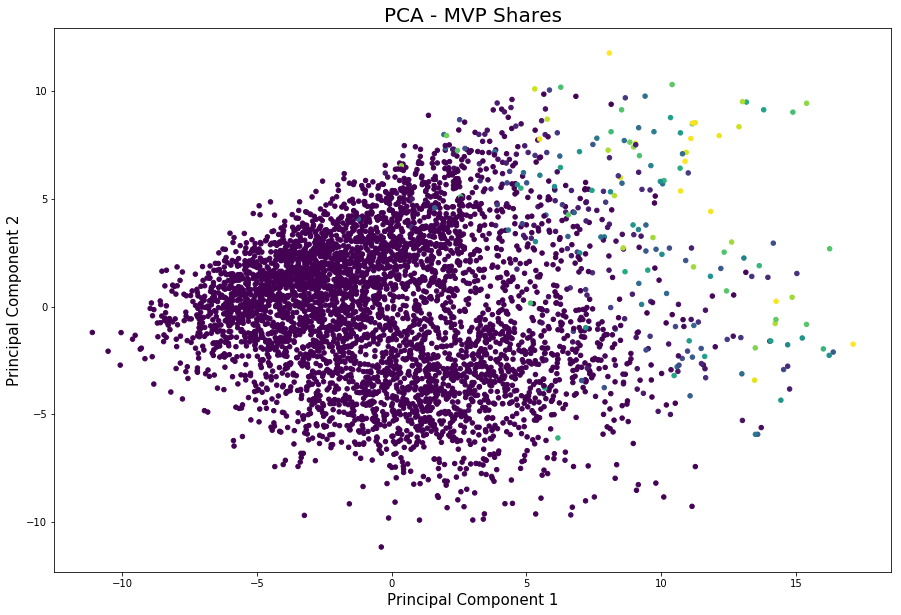

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pca_features = season_stats.drop(['Tm', 'Pos', 'Decade', 'MVP', 'MVP_Candidate',
                                 'MVPSHARES', 'Player'], axis=1)
x = pca_features
y = season_stats.loc[:, ['MVPSHARES']].values

x = StandardScaler().fit_transform(x)

pca = PCA(n_components=2)
principalcomponents = pca.fit_transform(x)
principalDF = pd.DataFrame(data = principalcomponents, columns = ['pc1', 'pc2'] )
principalDF = principalDF.reset_index(drop=True)

mvp_share = season_stats[['MVPSHARES']]
mvp_share = mvp_share.reset_index(drop=True)
finalDF = pd.concat([principalDF, mvp_share], axis=1)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(x = finalDF.pc1, y = finalDF.pc2, 
        c = finalDF['MVPSHARES'], s=20)
plt.title('PCA - MVP Shares', size = 20)
plt.xlabel('Principal Component 1', size=15)
plt.ylabel('Principal Component 2', size=15)
plt.show()

## Feature Selection ##
With 65 features what's a budding data scientist to do!  A number of things, but the first thing I did was print out a correlation heatmap of all my features. Obviously, feature correlation is a big problem.  This was something I wasn't too surprised with however, since I had features like total rebound along with their component parts defensive rebound and offensive rebound all in the same dataframe.  The first order of business was to remove a lot of these highly correlated stats (field goals made vs 3 point field goals made vs 2 point field goals made, etc).

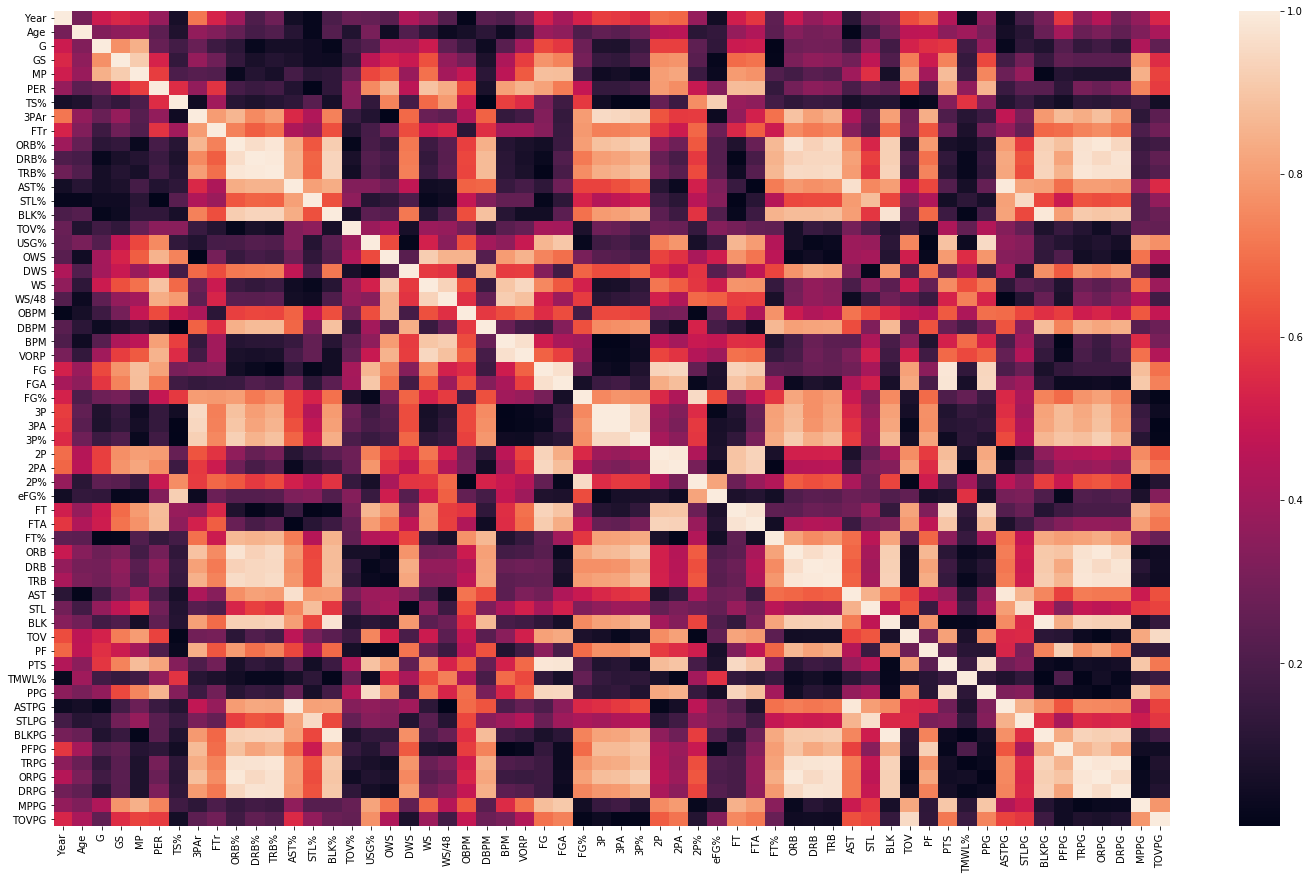

In [4]:
corr = season_stats.drop(['MVPSHARES', 'MVP_Candidate', 
                       'MVP', 'Tm', 'Player', 'Decade', 'Pos'], axis=1).corr()

corrmap = corr.corr().abs()
fig, ax = plt.subplots(figsize=(25, 15))
ax = sns.heatmap(corrmap)

## Feature Importance and Variance Inflation Factor ##
Along with doing some manual pruning, I ran the data through two different regression learning methods, RandomForestRegressor() and GradientBoostingRegressor(), then using the feature importance attribute to get a list of the methods most important features.  I did this for both and then compared the results to look for what features were really worth keeping.

In [5]:
# Run the model with all features to get feature importance
from sklearn.model_selection import train_test_split

y = season_stats['MVPSHARES']
X = season_stats.drop(['MVPSHARES', 'MVP_Candidate', 
                       'MVP', 'Tm', 'Player', 'Decade', 'Pos'], axis=1)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf.fit(X_train, y_train)

importance = pd.DataFrame()
importance['features'] = X_train.columns
importance['scores'] = rf.feature_importances_

importance.sort_values('scores', ascending=False).head(10)

,features,scores
19,WS,0.339962
5,PER,0.132232
47,TMWL%,0.109406
20,WS/48,0.034465
26,FGA,0.026713
16,USG%,0.024374
18,DWS,0.019900
32,2PA,0.018644
24,VORP,0.017622
25,FG,0.015425


In [6]:
from sklearn.ensemble import GradientBoostingRegressor

y = season_stats['MVPSHARES']
X = season_stats.drop(['MVPSHARES', 'MVP_Candidate', 
                       'MVP', 'Tm', 'Player', 'Decade', 'Pos'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)

importance = pd.DataFrame()
importance['features'] = X_train.columns
importance['scores'] = gbr.feature_importances_

importance.sort_values('scores', ascending=False).head(10)

,features,scores
47,TMWL%,0.121556
19,WS,0.072452
57,TOVPG,0.061817
5,PER,0.055630
18,DWS,0.051647
20,WS/48,0.051084
24,VORP,0.038822
17,OWS,0.028531
22,DBPM,0.028378
6,TS%,0.026427


## Variance Inflation Factor ##
Along with feature importance, I calculated variance inflation factors for all of the variables, recalculating them each time I removed a feature.

In [7]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools import add_constant

df = season_stats.drop(['MVPSHARES', 'MVP_Candidate', 
                       'MVP', 'Tm', 'Player', 'Decade', 'Pos'], axis=1)
X = add_constant(df)
var = pd.Series([variance_inflation_factor(X.values, i)
         for i in range (X.shape[1])],
          index=X.columns)

var = pd.DataFrame(var, columns = ['vif_score'])
var.sort_values('vif_score', ascending=False)

,vif_score
3P,inf
FG,inf
DRPG,inf
ORPG,inf
TRPG,inf
PTS,inf
TRB,inf
DRB,inf
ORB,inf
FT,inf


## Features! ##
 - Team Win/Loss % (TMWL%)
    -  Ex. 27-55 team record = .329 TMWL%
 - Player Efficiency Rating (PER)
    -  A measure of per-minute production standardized such that the league average is 15.
 - Points Per Game (PPG)
 - Win Share (WS)
    -  An estimate of the number of wins contributed by a player
 - Boxscore Plus Minus (BPM)
    -  A box score estimate of the points per 100 possessions a player contributed above a league-average player, translated to an average team.


In [8]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools import add_constant

feat_todrop = ['FG', 'FGA', '3P','3PA', '2P', '2PA', 'Tm', 'Pos', 'Player', 'Decade',
               'MVPSHARES', 'MVP_Candidate', 'MVP', 'ORPG', 'OWS', 'TRB%', 'BPM', 'TRPG', 'FG%', 'MP', 'TOV',
              'FT', 'FTA', 'WS/48', 'ASTPG', 'BLKPG', 'PPG', 'STLPG', 'DRPG', 'PF',
              'TRB', 'PTS', 'STL', 'TOVPG', 'AST%', 'BLK%', '2P%', 'DWS', 'G', 'GS', 'Age', 'Year', 'ORB%', 'DRB%']
feat_to_use = ['WS', 'PER', 'TMWL%', 'PPG', 'BPM']
               
df = season_stats[feat_to_use]
X = add_constant(df)
vif = pd.Series([variance_inflation_factor(X.values, i)
         for i in range (X.shape[1])],
          index=X.columns)
vif = pd.DataFrame(vif, columns = ['vif_score'])
vif.sort_values('vif_score', ascending=False)

,vif_score
const,67.216576
PER,5.833101
WS,5.214202
BPM,3.930752
PPG,2.934180
TMWL%,1.645705


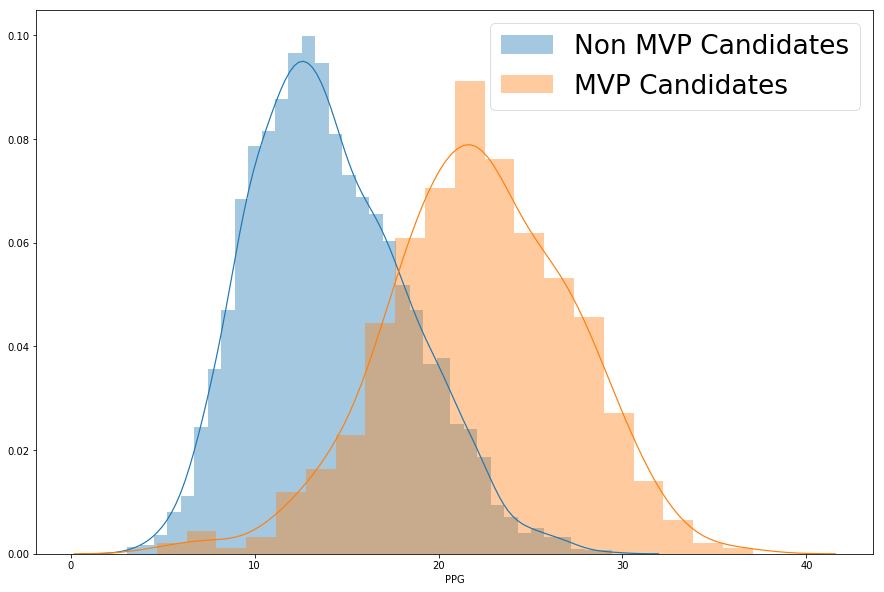

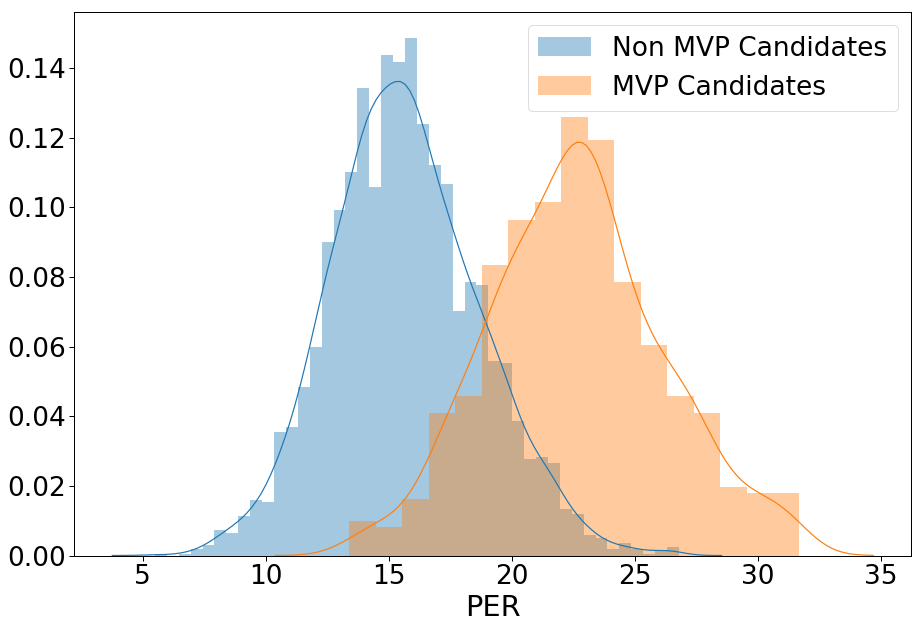

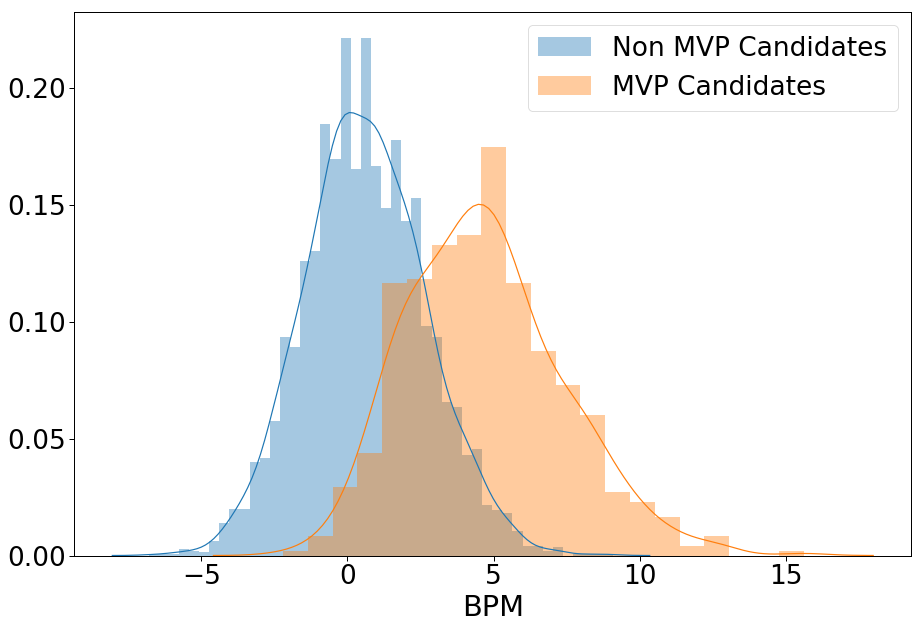

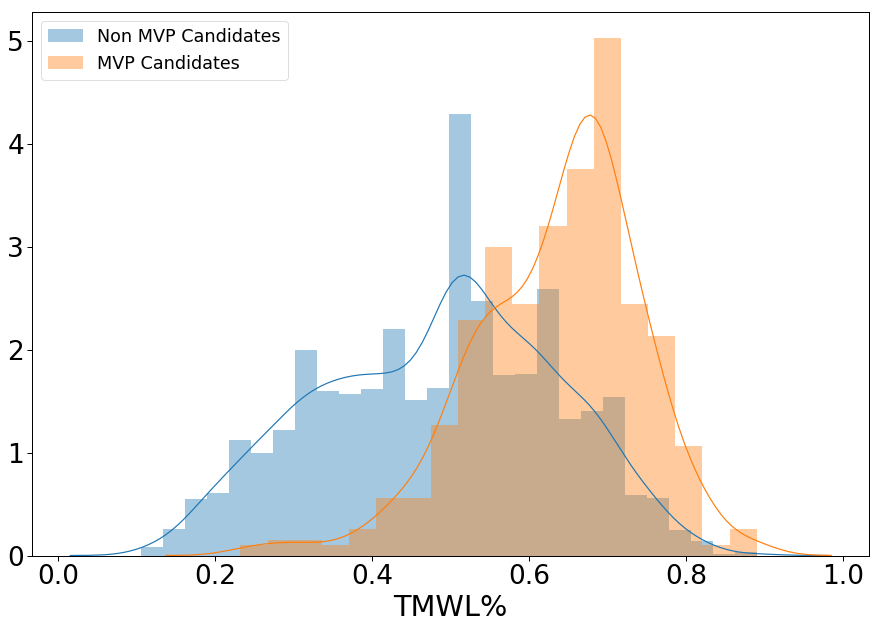

In [9]:
mvps = season_stats[season_stats['MVPSHARES'] > 0]
not_mvps = season_stats[season_stats['MVPSHARES'] == 0]

fig, ax = plt.subplots(figsize=(15, 10))
sns.set_context("paper", font_scale=3)
sns.distplot(not_mvps['PPG'], label='Non MVP Candidates', ax=ax)
sns.distplot(mvps['PPG'],label='MVP Candidates', ax=ax)
plt.legend()

fig, ax = plt.subplots(figsize=(15, 10))
sns.set_context("paper", font_scale=3)
sns.distplot(not_mvps['PER'], label='Non MVP Candidates', ax=ax)
sns.distplot(mvps['PER'], label='MVP Candidates', ax=ax)
plt.legend()

fig, ax = plt.subplots(figsize=(15, 10))
sns.set_context("paper", font_scale=3)
sns.distplot(not_mvps['BPM'], label='Non MVP Candidates', ax=ax)
sns.distplot(mvps['BPM'], label='MVP Candidates', ax=ax)
plt.legend()

fig, ax = plt.subplots(figsize=(15, 10))
sns.set_context("paper", font_scale=2)
sns.distplot(not_mvps['TMWL%'], label='Non MVP Candidates', ax=ax)
sns.distplot(mvps['TMWL%'], label='MVP Candidates', ax=ax)

plt.legend()
plt.show()

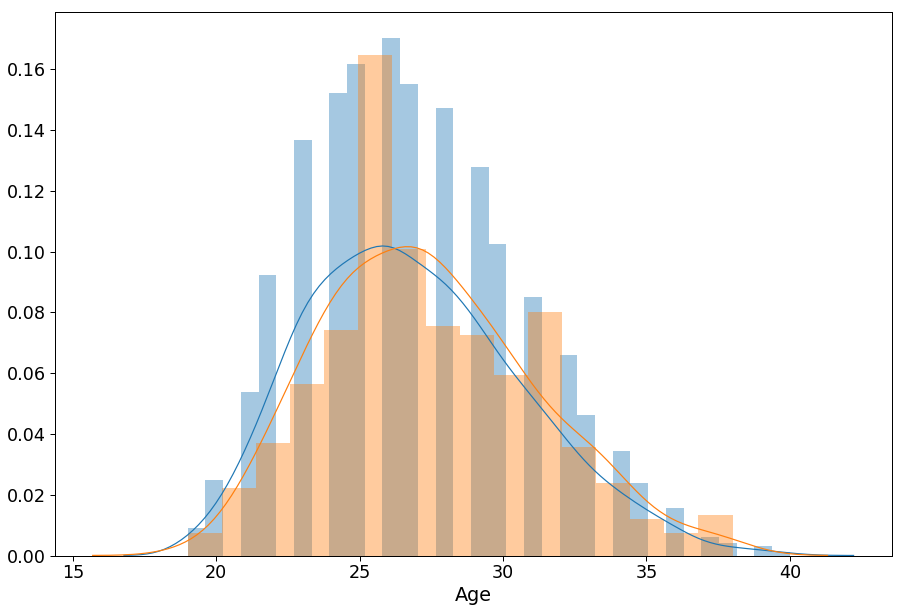

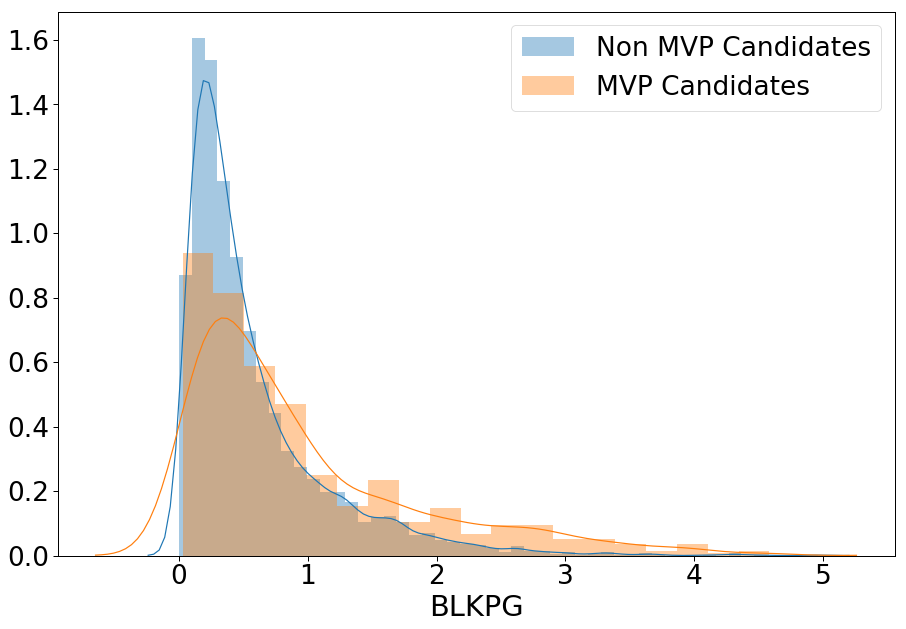

In [10]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.set_context("paper", font_scale=3)
sns.distplot(not_mvps['Age'])
sns.distplot(mvps['Age'])

fig, ax = plt.subplots(figsize=(15, 10))
sns.set_context("paper", font_scale=3)
sns.distplot(not_mvps['BLKPG'], label='Non MVP Candidates', ax=ax)
sns.distplot(mvps['BLKPG'], label='MVP Candidates', ax=ax)

plt.legend()
plt.show()

## Model Selection: Linear Regression ##
With the feature selection process over, I looked at using linear regression techniques to see if that was a simple, yet effective way to predict and explain the inputs into my model.  Unfortunately, the model did not perform particularly well initially due to it's violation of the linear regression law of multivariate normality.  In the plot below, residuals look evenly distributed initially but they extend out far to the right due to the prevalence of zero values in the dependent variable.  I attemped to improve on this model by performing log and squareroot transformations of the dependent variable, but neither of those options proved much more effective.

Coefficients: 
 [0.00697586 0.00320655 0.02126317 0.00204985 0.00243458]
Intercept: 
 -0.12013819346580076
Score: 
 0.28615695571299826


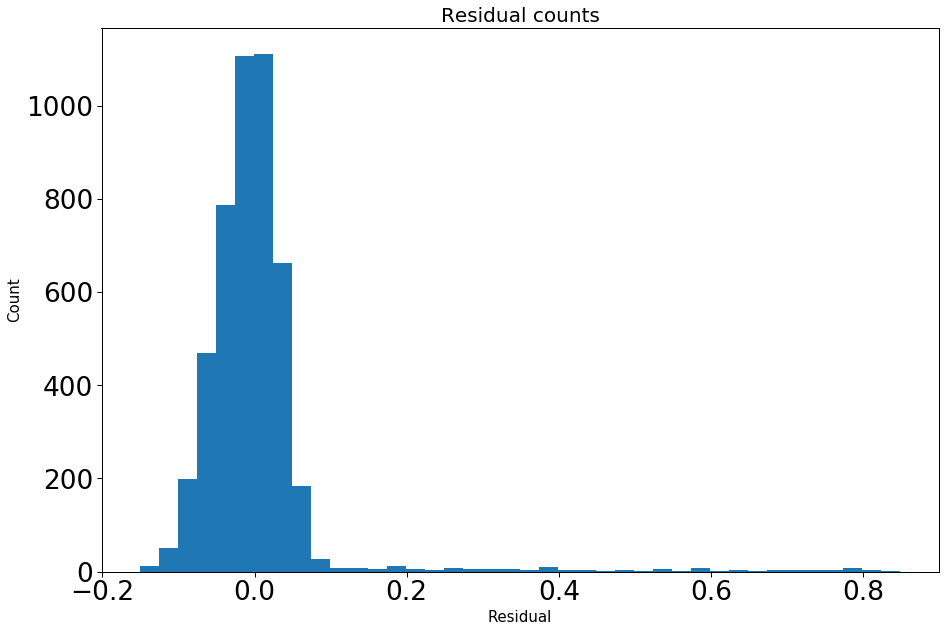

In [11]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split

y = season_stats['MVPSHARES']
X = df

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
print('Coefficients: \n', regr.coef_)
print('Intercept: \n', regr.intercept_)
print('Score: \n', regr.score(X_test, y_test))

predicted = regr.predict(X).ravel()
actual = season_stats['MVPSHARES']

residual = actual - predicted

fig = plt.figure(figsize=(15,10))
plt.hist(residual, bins=40)
plt.title('Residual counts', size = 20)
plt.xlabel('Residual', size = 15)
plt.ylabel('Count', size = 15)
plt.show()

Coefficients: 
 [0.00537729 0.00262377 0.01721495 0.00162915 0.00193834]
Intercept: 
 -0.09574545179568271
Score: 
 0.3068600059750519


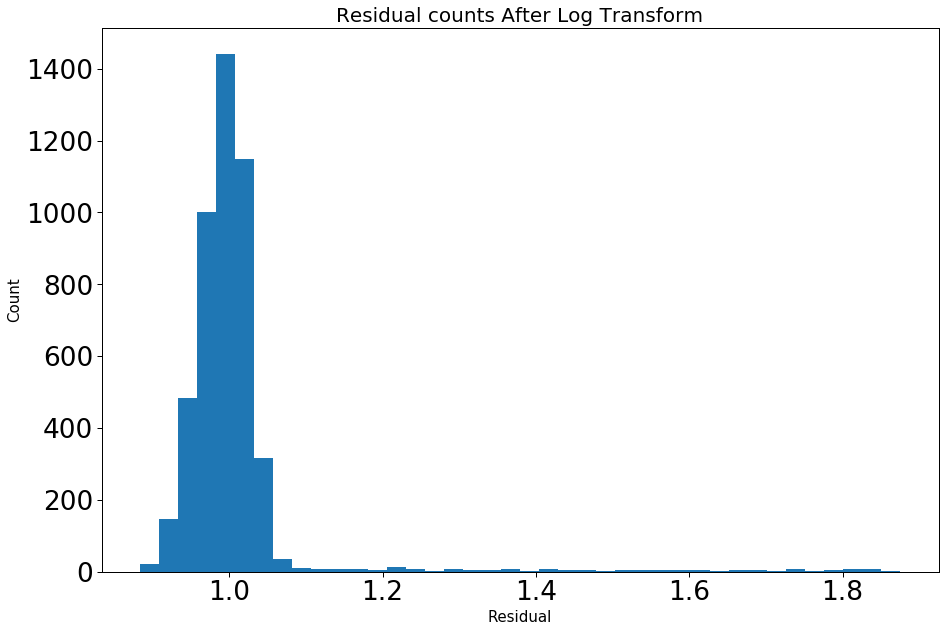

In [12]:
season_stats['MVPSHARES_PLUS_1'] = season_stats['MVPSHARES'] + 1

y = np.log(season_stats['MVPSHARES_PLUS_1'])
X = df

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
print('Coefficients: \n', regr.coef_)
print('Intercept: \n', regr.intercept_)
print('Score: \n', regr.score(X_test, y_test))

predicted = regr.predict(X).ravel()
actual = season_stats['MVPSHARES_PLUS_1']

residual = actual - predicted

fig = plt.figure(figsize=(15,10))
plt.hist(residual, bins=40)
plt.title('Residual counts After Log Transform', size = 20)
plt.xlabel('Residual', size = 15)
plt.ylabel('Count', size = 15)
plt.show()

Coefficients: 
 [0.00304944 0.00144671 0.00953592 0.00090996 0.00108243]
Intercept: 
 0.9465608672094188
Score: 
 0.2968521103273608


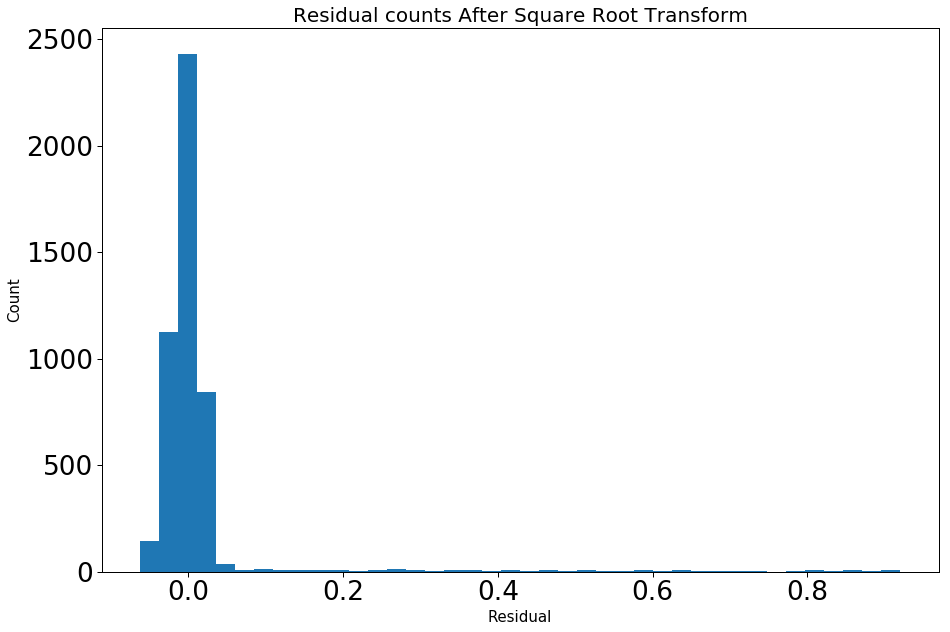

In [13]:
season_stats['MVPSHARES_PLUS_1'] = season_stats['MVPSHARES'] + 1

y = np.sqrt(season_stats['MVPSHARES_PLUS_1'])
X = df

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
print('Coefficients: \n', regr.coef_)
print('Intercept: \n', regr.intercept_)
print('Score: \n', regr.score(X_test, y_test))

predicted = regr.predict(X).ravel()
actual = season_stats['MVPSHARES_PLUS_1']

residual = actual - predicted

fig = plt.figure(figsize=(15,10))
plt.hist(residual, bins=40)
plt.title('Residual counts After Square Root Transform', size = 20)
plt.xlabel('Residual', size = 15)
plt.ylabel('Count', size = 15)
plt.show()

### Model Selection: Gradient Boosting Vs Random Forest ###
During the inital testing phases when I was running the models with all features in order to gather feature importance rankings.  Both models performed relatively similarly when I calculated scores for each.  Because of my familiarity with it however, I elected to go with RandomForrestRegressor 

In [14]:
rf = RandomForestRegressor(random_state = 42)
rf.fit(X_train, y_train)
print(cross_val_score(rf, X_test, y_test, cv=5))
print(rf.score(X_test,y_test))

[0.61485435 0.76084906 0.59810883 0.65789293 0.7413013 ]
0.7148797333811812


In [15]:
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


## Tuning the Random Forest Regressor Model ##
To tune the random forest model, I used RandomizedSearchCV in order to do a randomized search of the best parameters for the random forest model, according to a search grid that was setup for each parameter.

In [16]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

max_features = ['auto', 'sqrt']

max_depth = [int(x) for x in np.linspace(10, 110, num= 11)]
max_depth.append(None)

min_samples_split = [2, 5, 10]

min_samples_leaf = [1, 2, 4]

bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators, 
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [17]:
rf = RandomForestRegressor()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
                              n_iter = 100, cv = 3, verbose=2, random_state=42,
                              n_jobs = -1)

rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   58.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  8.6min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [18]:
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 30,
 'bootstrap': True}

In [19]:
best_random = rf_random.best_estimator_
print(cross_val_score(best_random, X_test, y_test, cv=5))
print(best_random.score(X_test,y_test))

[0.67996568 0.77378419 0.67556371 0.68420835 0.75702801]
0.7610249465836916


### Tuning: GridSearchCV ###
After getting the preferred params from RandomizedSearch, I used those parameters as the basis for starting another search grid, only this time with GridSearchCV, which is an exhaustive search across all combinations of parameters instead of a random search.

In [20]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search
param_grid = {
    'bootstrap': [True],
    'max_depth': [20, 30, 40, 50, 60, 70, 80],
    'max_features': [2, 3, 4, 'auto', 'sqrt'],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [2, 4, 6],
    'n_estimators': [100, 200, 300, 400, 800]
}

rf = RandomForestRegressor()

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 1575 candidates, totalling 4725 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   53.8s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 22.3min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 27.4min
[Parallel(n_jobs=-1)]: Done 4725 out of 4725 | elapsed: 32.1min finished


{'bootstrap': True,
 'max_depth': 30,
 'max_features': 'auto',
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 200}

In [21]:
best_grid = grid_search.best_estimator_
best_grid

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [22]:
print(cross_val_score(best_grid, X_test, y_test, cv=5))
print(best_grid.score(X_test,y_test))

[0.59753413 0.7762984  0.6719347  0.67963188 0.75468603]
0.7618576603718258


### Tuning: Number of Trees & Max Features ###
Finally, I used gridsearchcv to chart out changes to R2 as I changed the number of trees in the forest or the number of features to consider when looking for the best split (while holding everything else constant). For trees, after around a 100 or so, the gains become insignificant, while changing the max features paramter did not seem to have much of an effect on the score.

In [23]:
# Grid with only the number of trees changed
tree_grid = {'n_estimators': [int(x) for x in np.linspace(1, 1000, 30)]}

# Create the grid search model and fit to the training data
tree_grid_search = GridSearchCV(rf, param_grid=tree_grid, verbose = 2, n_jobs=-1, cv = 3,
                                scoring = 'r2')
tree_grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.4min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [1, 35, 69, 104, 138, 173, 207, 242, 276, 311, 345, 379, 414, 448, 483, 517, 552, 586, 621, 655, 689, 724, 758, 793, 827, 862, 896, 931, 965, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=2)

In [24]:
tree_grid_search.cv_results_

{'mean_fit_time': array([1.09826724e-02, 3.00570885e-01, 8.04506063e-01, 1.32046509e+00,
        1.73171329e+00, 2.18083564e+00, 2.63497035e+00, 3.06713311e+00,
        3.47936424e+00, 3.94046521e+00, 4.31878797e+00, 4.74631031e+00,
        5.21112521e+00, 5.65386613e+00, 6.08040984e+00, 6.48732241e+00,
        6.92581630e+00, 7.43545556e+00, 7.81779329e+00, 8.22800159e+00,
        8.82573732e+00, 9.15352718e+00, 9.55441984e+00, 9.98105001e+00,
        1.03619728e+01, 1.08563086e+01, 1.12605811e+01, 1.17252853e+01,
        1.12226624e+01, 1.00069304e+01]),
 'std_fit_time': array([0.00079783, 0.0079097 , 0.13447587, 0.03839379, 0.03035179,
        0.05010828, 0.09873468, 0.073818  , 0.07855229, 0.06981795,
        0.10420862, 0.10556983, 0.08581013, 0.11917503, 0.14332283,
        0.15455864, 0.29012883, 0.02692202, 0.19603759, 0.16017214,
        0.19083605, 0.15727181, 0.14869092, 0.2213921 , 0.12506336,
        0.23615303, 0.17559743, 0.25849402, 0.52396733, 0.59480309]),
 'mean_scor

In [25]:
def plot_results(model, param = 'n_estimators', name = 'Number of Trees'):
    param_name = 'param_%s' % param

    # Extract information from the cross validation model
    train_scores = model.cv_results_['mean_train_score']
    test_scores = model.cv_results_['mean_test_score']
    train_time = model.cv_results_['mean_fit_time']
    param_values = list(model.cv_results_[param_name])
    
    # Plot the scores over the parameter
    plt.subplots(1, 2, figsize=(25, 10))
    plt.subplot(121)
    plt.plot(param_values, train_scores, 'bo-', label = 'train')
    plt.plot(param_values, test_scores, 'go-', label = 'test')
    plt.ylim(ymin = 0, ymax = 1)
    plt.legend()
    plt.xlabel(name)
    plt.ylabel('R2 Score')
    plt.title('Score vs %s' % name)
    
    plt.subplot(122)
    plt.plot(param_values, train_time, 'ro-')
    plt.ylim(ymin = 0.0, ymax = 4.0)
    plt.xlabel(name)
    plt.ylabel('Train Time (sec)')
    plt.title('Training Time vs %s' % name)
    
    
    plt.tight_layout(pad = 4)

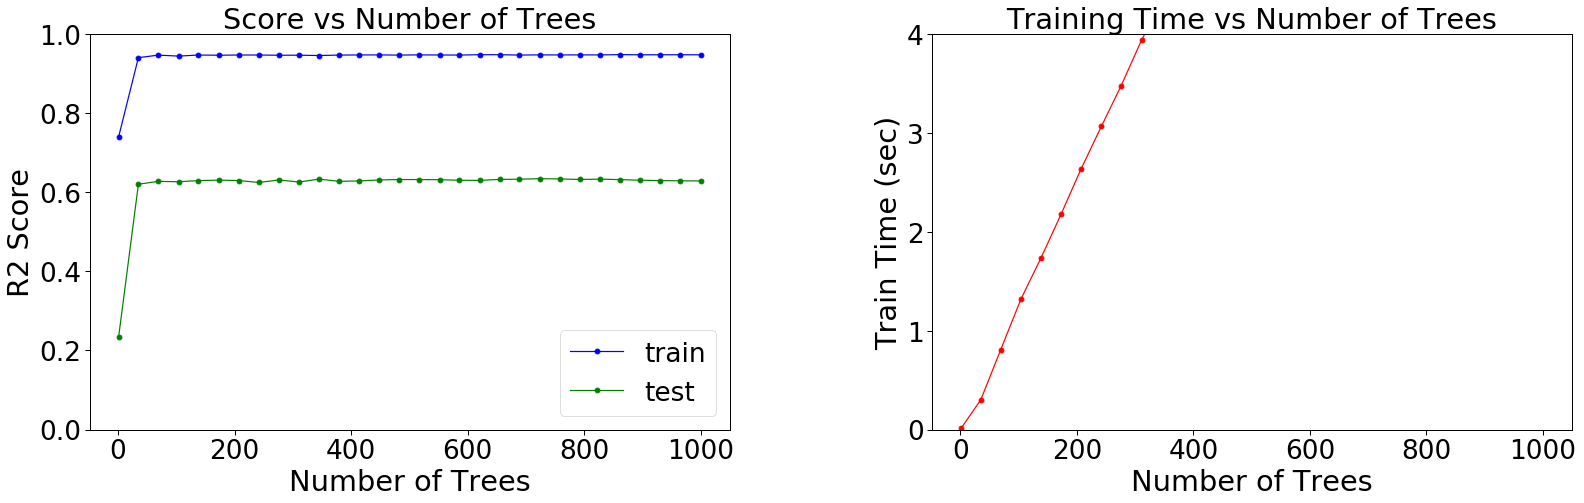

In [29]:
plot_results(tree_grid_search)

In [33]:
feature_grid = {'max_features': list(range(1, X_train.shape[1] + 1))}
feature_grid_search = GridSearchCV(rf, param_grid=feature_grid, cv = 3, n_jobs=-1, verbose= 2,
                                  scoring = 'r2')
feature_grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    9.2s remaining:    8.0s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    9.2s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_features': [1, 2, 3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=2)

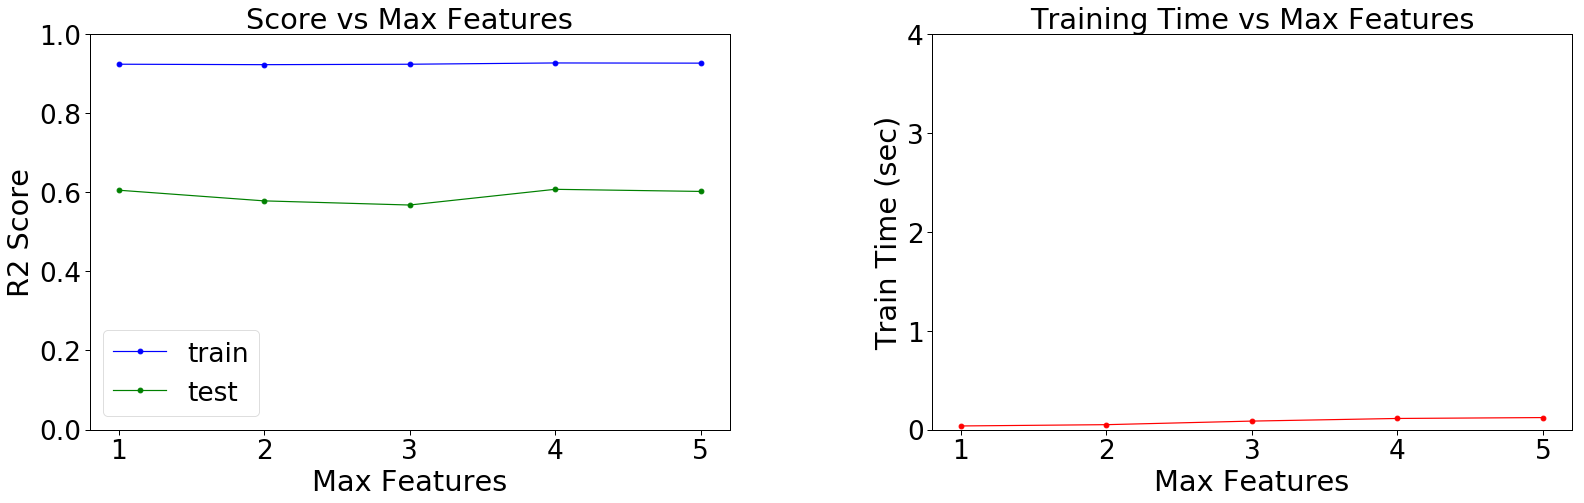

In [34]:
plot_results(feature_grid_search, param='max_features', name = 'Max Features')

In [36]:
rf = RandomForestRegressor(bootstrap = True, max_depth = 30, max_features = 'auto',
                           min_samples_leaf = 3, min_samples_split = 2,
                           n_estimators = 400)
rf.fit(X_train, y_train)

print(cross_val_score(rf, X_test, y_test, cv=5))
print(rf.score(X_test,y_test))

[0.62263822 0.7752007  0.66857768 0.68510822 0.75520401]
0.7694818954652459


In [98]:
# Test Data
season_2018 = pd.read_csv('2018_season.csv')
season_2018 = season_2018.drop(['blanl', 'blank2'], axis=1)
season_2018 = season_2018[season_2018.Tm.str.contains('TOT') == False]
# Maybe use this for classification?
season_2018['MVP_Candidate'] = np.where(season_2018['MVPSHARES'] > 0, 'Yes', 'No')
season_2018['Player'] = season_2018['Player'].astype(str).str.replace('*', '')
season_2018['PPG'] = season_2018['PTS'] / season_2018['G']
season_2018['ASTPG'] = season_2018['AST'] / season_2018['G']
season_2018['STLPG'] = season_2018['STL'] / season_2018['G']
season_2018['BLKPG'] = season_2018['BLK'] / season_2018['G']
season_2018['PFPG'] = season_2018['PF'] / season_2018['G']
season_2018['TRPG'] = season_2018['TRB'] / season_2018['G']
season_2018['ORPG'] = season_2018['ORB'] / season_2018['G']
season_2018['DRPG'] = season_2018['DRB'] / season_2018['G']
season_2018['MPPG'] = season_2018['MP'] / season_2018['G']

season_2018 = season_2018[season_2018['G'] >= 41.0]
season_2018 = season_2018[season_2018['MPPG'] >= 25.0]
season_2018 = season_2018.dropna()

## Predictions! ## 
Now that the model has been tuned, it's time to see how it did.  Looking back at the past three years of NBA MVP winners it predicted two correctly.  Not bad!  What's more (or less?) encouraging is that the one it got wrong (2017 year) was due more to narrative than anything else.  Russell Westbrook had a statistical year that was only slightly above his usual averages, but the narrative of him averaging a triple double (something that hadn't been done since the 60's) got him the vote even when he wasn't playing that much better than he was prior to that year (or the next) and his team only won 47 out of 82 games that year, which is on the lower end of the spectrum for team wins by an MVP.  Overall though, not a bad showing!

In [99]:
test_pred = rf.predict(season_2018[feat_to_use])
test_results = pd.DataFrame(season_2018.Player)
test_results['score'] = test_pred
test_results['Year'] = season_2018['Year']
test_results['Share'] = season_2018['MVPSHARES']
test_results['MVP'] = season_2018['MVP']
test_results.sort_values('score', ascending=False).head()

,Player,score,Year,Share,MVP
232,James Harden,0.775316,2018,0.955,1
303,LeBron James,0.316129,2018,0.731,0
146,Stephen Curry,0.297045,2018,0.005,0
148,Anthony Davis,0.257955,2018,0.441,0
171,Kevin Durant,0.223396,2018,0.065,0


In [102]:
season_2017 = season_stats[season_stats['Year'] == 2017.0]
season_not2017 = season_stats[season_stats['Year'] != 2017.0]

X = season_not2017[feat_to_use]
y = season_not2017['MVPSHARES']
rf = RandomForestRegressor(bootstrap = True, max_depth = 80, max_features = 3,
                           min_samples_leaf = 3, min_samples_split = 3,
                           n_estimators = 400)
rf.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=80,
           max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=3,
           min_samples_split=3, min_weight_fraction_leaf=0.0,
           n_estimators=400, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [103]:
test_pred = rf.predict(season_2017[feat_to_use])
test_results = pd.DataFrame(season_2017.Player)
test_results['score'] = test_pred
test_results['Year'] = season_2017['Year']
test_results['Share'] = season_2017['MVPSHARES']
test_results['MVP'] = season_2017['MVP']
test_results.sort_values('score', ascending=False).head()

,Player,score,Year,Share,MVP
24414,Kawhi Leonard,0.565860,2017,0.495,0
24216,Stephen Curry,0.512728,2017,0.051,0
24239,Kevin Durant,0.474456,2017,0.002,0
24306,James Harden,0.444739,2017,0.746,0
24654,Russell Westbrook,0.333496,2017,0.879,1


In [104]:
season_2016 = season_stats[season_stats['Year'] == 2016.0]
season_not2016 = season_stats[season_stats['Year'] != 2016.0]

X = season_not2016[feat_to_use]
y = season_not2016['MVPSHARES']
rf = RandomForestRegressor(bootstrap = True, max_depth = 80, max_features = 3,
                           min_samples_leaf = 3, min_samples_split = 3,
                           n_estimators = 400)
rf.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=80,
           max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=3,
           min_samples_split=3, min_weight_fraction_leaf=0.0,
           n_estimators=400, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [105]:
test_pred = rf.predict(season_2016[feat_to_use])
test_results = pd.DataFrame(season_2016.Player)
test_results['score'] = test_pred
test_results['Year'] = season_2016['Year']
test_results['Share'] = season_2016['MVPSHARES']
test_results['MVP'] = season_2016['MVP']
test_results.sort_values('score', ascending=False).head()

,Player,score,Year,Share,MVP
23633,Stephen Curry,0.928831,2016,1.000,1
23839,Kawhi Leonard,0.504936,2016,0.484,0
23781,LeBron James,0.456614,2016,0.482,0
24070,Russell Westbrook,0.378227,2016,0.371,0
23654,Kevin Durant,0.336302,2016,0.112,0
